In [1]:
! git clone https://github.com/jonassoleil/swag.git
! pip install wandb

Cloning into 'swag'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (361/361), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 361 (delta 198), reused 281 (delta 122), pack-reused 0
Receiving objects: 100% (361/361), 137.94 KiB | 15.33 MiB/s, done.
Resolving deltas: 100% (198/198), done.
     |████████████████████████████████| 2.1MB 16.3MB/s 
     |████████████████████████████████| 102kB 10.6MB/s 
     |████████████████████████████████| 133kB 44.6MB/s 
     |████████████████████████████████| 163kB 45.5MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=565cb79c0c7835e960b041b31dad2c6ac0a0be66d5b865cfc002b9cf765b9c29
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=8915476b5fefe053581eb33d

In [2]:
cd swag/

/content/swag


In [3]:
! git checkout janek_dev
! git pull

Branch 'janek_dev' set up to track remote branch 'janek_dev' from 'origin'.
Switched to a new branch 'janek_dev'
Already up to date.


In [4]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from  src.utils.load_utils import download_checkpoint
from tqdm.notebook import tqdm

def get_preds(run_id, suffix=''):
  download_checkpoint(run_id, f'predictions{suffix}.npy')
  download_checkpoint(run_id, f'targets.npy')
  predictions = np.load(f'predictions{suffix}.npy')
  targets = np.load('targets.npy')
  return predictions, targets

## Compare accuracies

In [5]:
def get_acc_with_std(preds, targets, n_samples, n=100):
  n = preds.shape[0]
  accuracies = []
  for i in range(n):
    indices = np.random.choice(list(range(n)), size=n_samples, replace=False)
    acc = accuracy_score(targets, preds[indices].mean(axis=0).argmax(axis=1))
    accuracies.append(acc)
  return np.mean(accuracies), np.std(accuracies), np.percentile(accuracies, 5), np.percentile(accuracies, 95)

### CIFAR10

In [72]:
predictions, targets = get_preds('3rxjjlx1') # Ensemble CIFAR10
acc_single = []
acc_ensemble = []
for i in range(predictions.shape[0]):
  acc_single.append(accuracy_score(targets, predictions[-i-1].argmax(axis=1)))
  acc_ensemble.append(accuracy_score(targets, predictions[-i-1:].mean(axis=0).argmax(axis=1)))
acc_swa = []
for i in range(2,26):
  preds, _ = get_preds('8mvqdjc1', f'_k{i}') # SWA CIFAR10
  acc_swa.append(accuracy_score(targets, preds.mean(axis=0).argmax(axis=1)))

# SWAG
acc_swag = []
k_swag = [3, 5, 8, 10, 16]

preds, _ = get_preds('2sjbgi3y') # SWAG 256, k=3
acc, std, _ , _  = get_acc_with_std(preds, targets, n_samples=64)
acc_swag.append(acc)

preds, _ = get_preds('3vkd6gg2') # SWAG 256, k=5 (also 3mgr2rnt, different seed)
acc, std, _ , _  = get_acc_with_std(preds, targets, n_samples=64)
acc_swag.append(acc)

preds, _ = get_preds('11t47era') # SWAG 256, k=8
acc, std, _ , _  = get_acc_with_std(preds, targets, n_samples=64)
acc_swag.append(acc)

preds, _ = get_preds('1tc0el95') # SWAG 256, k=10
acc, std, _ , _  = get_acc_with_std(preds, targets, n_samples=64)
acc_swag.append(acc)

preds, _ = get_preds('wu6eg434') # SWAG 128, k=16
acc, std, _ , _  = get_acc_with_std(preds, targets, n_samples=64)
acc_swag.append(acc)

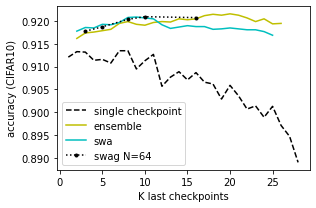

In [78]:
# plt.figure(figsize=(10,6))
plt.figure(figsize=(4.5,3))
k = np.arange(1, predictions.shape[0] + 1)
plt.plot(k, acc_single, 'k--', label='single checkpoint')
plt.plot(k[1:26], acc_ensemble[1:26], 'y', label='ensemble')
plt.plot(k[1:25], acc_swa, 'c', label='swa')
plt.plot(k_swag, acc_swag, 'k.:', label='swag N=64')
plt.xlabel('K last checkpoints')
plt.ylabel('accuracy (CIFAR10)')
plt.xticks([0,5,10,15,20,25])
plt.legend()
plt.tight_layout()

In [79]:
preds1, targets = get_preds('3vkd6gg2') # SWAG 256, k=5 
preds2, _ = get_preds('3mgr2rnt') # SWAG 256, k=5 (different seed)
preds = np.concatenate([preds1, preds2], axis=0)
del preds1
del preds2

samples = []
accuracies = []
stds = []
los = []
his = []
for i in tqdm([2,4,8,16,32,64,128,256,512]):
  acc, std, lo5, hi5 = get_acc_with_std(preds, targets, n_samples=i, n=200)
  accuracies.append(acc)
  los.append(lo5)
  his.append(hi5)
  samples.append(i)

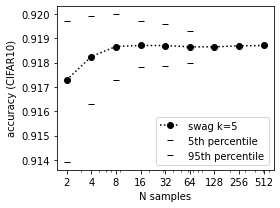

In [80]:
plt.figure(figsize=(4,3))
plt.plot(samples, accuracies, 'ko:',label='swag k=5')

# omit last few because sampling without replacement from total of 512
# TODO: ask if this is ok?
plt.plot(samples[:-3], los[:-3], 'k_', label='5th percentile')
plt.plot(samples[:-3], his[:-3], 'k_', label='95th percentile')

plt.xlabel('N samples')
plt.ylabel('accuracy (CIFAR10)')
plt.legend()
plt.xscale('log')
plt.xticks([2,4,8,16,32,64,128,256,512], [2,4,8,16,32,64,128,256,512]);
plt.tight_layout()

### CIFAR100

In [11]:
predictions, targets = get_preds('6rur0243') # Ensemble CIFAR100
acc_single = []
acc_ensemble = []
for i in range(predictions.shape[0]):
  acc_single.append(accuracy_score(targets, predictions[-i-1].argmax(axis=1)))
  acc_ensemble.append(accuracy_score(targets, predictions[-i-1:].mean(axis=0).argmax(axis=1)))
acc_swa = []
for i in range(2,22):
  preds, _  = get_preds('373xmyi4', f'_k{i}') # SWA CIFAR100
  acc_swa.append(accuracy_score(targets, preds.mean(axis=0).argmax(axis=1)))

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
swag_k = [2,3,4,5,6,7,8,9,10,16]
acc_swag64 = []

for i in range(2,5):
  preds, _ = get_preds('3l03q84b', f'_k{i}') # SWAG CIFAR100 K = {2,3,4}
  acc_swag64.append(accuracy_score(targets, preds.mean(axis=0).argmax(axis=1)))


preds, _ = get_preds('1l1zic13', '_k5') # SWAG CIFAR100 K=5
acc_swag64.append(accuracy_score(targets, preds.mean(axis=0).argmax(axis=1)))

for i in range(6,10):
  preds, _ = get_preds('d6790168', f'_k{i}') # SWAG CIFAR100 K= {6 - 9}
  acc_swag64.append(accuracy_score(targets, preds.mean(axis=0).argmax(axis=1)))

preds, _ = get_preds('3nmg5cky') # SWAG, K=10 (128)
print(accuracy_score(targets, preds.mean(axis=0).argmax(axis=1)))
acc, std, _ , _  = get_acc_with_std(preds, targets, n_samples=64)
acc_swag64.append(acc)

preds, _ = get_preds('36ykfzm1') # SWAG, K=16 (64)
acc_swag64.append(accuracy_score(targets, preds.mean(axis=0).argmax(axis=1)))
acc, std, _ , _  = get_acc_with_std(preds, targets, n_samples=16)

0.6835


([<matplotlib.axis.XTick at 0x7f983d400a90>,
 <a list of 5 Text major ticklabel objects>)

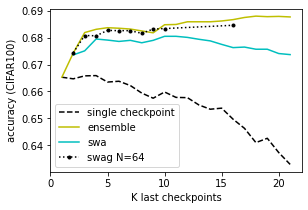

In [17]:
# plt.figure(figsize=(10,6))
plt.figure(figsize=(4.5,3))
k = np.arange(1, predictions.shape[0] + 1)
plt.plot(k, acc_single, 'k--', label='single checkpoint')
plt.plot(k, acc_ensemble, 'y', label='ensemble')
plt.plot(k[1:21], acc_swa, 'c', label='swa')
plt.plot(swag_k, acc_swag64, 'k.:', label='swag N=64')
plt.xlabel('K last checkpoints')
plt.ylabel('accuracy (CIFAR100)')
plt.legend()
plt.xticks([0,5,10,15,20])

In [14]:
preds1, targets = get_preds('f68xa8fk') # SWAG 256, k=5 
preds2, _ = get_preds('65r3pymj') # SWAG 256, k=5 (different seed)
preds = np.concatenate([preds1, preds2], axis=0)
del preds1
del preds2

samples = []
accuracies = []
stds = []
los = []
his = []
for i in tqdm([2,4,8,16,32,64,128,256,512]):
  acc, std, lo5, hi5 = get_acc_with_std(preds, targets, n_samples=i, n=200)
  accuracies.append(acc)
  los.append(lo5)
  his.append(hi5)
  samples.append(i)

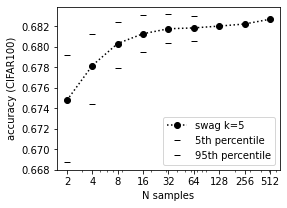

In [15]:
plt.figure(figsize=(4,3))
plt.plot(samples, accuracies, 'ko:',label='swag k=5')

# omit last few because sampling without replacement from total of 512
# TODO: ask if this is ok?
plt.plot(samples[:-3], los[:-3], 'k_', label='5th percentile')
plt.plot(samples[:-3], his[:-3], 'k_', label='95th percentile')

plt.xlabel('N samples')
plt.ylabel('accuracy (CIFAR100)')
plt.legend()
plt.xscale('log')
plt.xticks([2,4,8,16,32,64,128,256,512], [2,4,8,16,32,64,128,256,512]);

## Plot calibration curves

### CIFAR10

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib

def plot_calibration_curve(probabilities, targets, label=None, line=':.'):
  max_probs = probabilities.max(axis=1)
  correct = probabilities.argmax(axis=1) == targets
  
  # scale the x axis to get nice spacing
  xscale_fn = lambda x: -np.log10(1-x*0.999)
  tick_labels = np.array([0.2, 0.7, 0.9, 0.97, 0.99, 0.996, 0.999])
  # tick_labels = (1-np.power(10, - np.linspace(0.1,3,10)))/0.999
  tick_placement = xscale_fn(tick_labels)
  # plt.xticks(tick_placement, np.round(tick_labels,3))
  plt.xticks(tick_placement, tick_labels)

  # plot reference at 0
  plt.plot(xscale_fn(np.array([0, 1])), [0, 0], "k--")

  # calibration curve
  prob_true, prob_pred = calibration_curve(correct, max_probs, n_bins=20, strategy='quantile')
  plt.plot(xscale_fn(prob_pred), prob_pred - prob_true, line, label=label)
  
  plt.ylabel('Confidence - Accuracy')
  plt.xlabel('Confidence')

In [ ]:
predictions, targets = get_preds('3rxjjlx1') # Ensemble CIFAR10
swa_20, _ = get_preds('8mvqdjc1', f'_k20') # SWA 20

# SWAG
preds1, _ = get_preds('3vkd6gg2') # SWAG 256, k=5 
preds2, _ = get_preds('3mgr2rnt') # SWAG 256, k=5 (different seed)
swag_5 = np.concatenate([preds1, preds2], axis=0)
del preds1
del preds2
swag_8, _ = get_preds('11t47era') # SWAG 128, k=8
swag_16, _ = get_preds('wu6eg434') # SWAG 128, k=16

single = predictions[-1]
# ensemble_2 = predictions[-2:].mean(axis=0)
ensemble_5 = predictions[-5:].mean(axis=0)
ensemble_8 = predictions[-8:].mean(axis=0)
ensemble_16 = predictions[-16:].mean(axis=0)

Text(0.5, 1.0, 'Calibration curve (VGG16 on CIFAR10)')

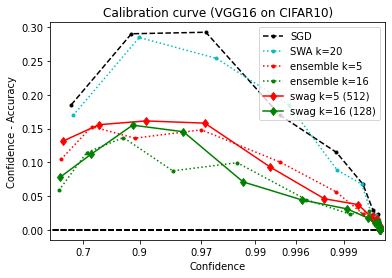

In [ ]:
# plt.figure(figsize=(12,12))
plt.figure(figsize=(6,4))
plot_calibration_curve(single, targets, label='SGD', line='k.--')
plot_calibration_curve(swa_20[0], targets, label='SWA k=20', line='c:.')
plot_calibration_curve(ensemble_5, targets, label='ensemble k=5', line='r:.')
# plot_calibration_curve(ensemble_8, targets, label='ensemble k=8', line=':.')
plot_calibration_curve(ensemble_16, targets, label='ensemble k=16', line='g:.')
plot_calibration_curve(swag_5.mean(axis=0), targets, label='swag k=5 (512)', line='rd-')
# plot_calibration_curve(swag_5[:32].mean(axis=0), targets, label='swag k=5 (32)', line='d-.')
# plot_calibration_curve(swag_5[:128].mean(axis=0), targets, label='swag k=5 (128)', line='d-.')
plot_calibration_curve(swag_16.mean(axis=0), targets, label='swag k=16 (128)', line='gd-')
# plot_calibration_curve(swag_8.mean(axis=0), targets, label='swag k=8 (128)', line='d-.')
plt.legend()
plt.xlim((0.25, -np.log10(1-0.9991)))
plt.title('Calibration curve (VGG16 on CIFAR10)')

### CIFAR100

In [ ]:
predictions, targets = get_preds('6rur0243') # Ensemble CIFAR100
swa_20, _ = get_preds('373xmyi4', f'_k20') # SWA 20
single = predictions[-1]
ensemble_2 = predictions[-2:].mean(axis=0)
ensemble_5 = predictions[-5:].mean(axis=0)
ensemble_8 = predictions[-8:].mean(axis=0)
ensemble_16 = predictions[-16:].mean(axis=0)
ensemble_20 = predictions[-20:].mean(axis=0)


# SWAG
preds1, _ = get_preds('f68xa8fk') # SWAG 256, k=5 
preds2, _ = get_preds('65r3pymj') # SWAG 256, k=5 (different seed)
swag_5 = np.concatenate([preds1, preds2], axis=0)
del preds1
del preds2
swag_8, _ = get_preds('d6790168', f'_k8') # SWAG 64, k=8
swag_16, _ = get_preds('36ykfzm1') # SWAG 128, k=16

Text(0.5, 1.0, 'Calibration curve (VGG16 on CIFAR100)')

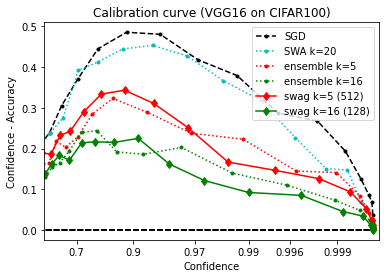

In [ ]:
# plt.figure(figsize=(12,12))
plt.figure(figsize=(6,4))
plot_calibration_curve(single, targets, label='SGD', line='k.--')
plot_calibration_curve(swa_20[0], targets, label='SWA k=20', line='c:.')
plot_calibration_curve(ensemble_5, targets, label='ensemble k=5', line='r:.')
# plot_calibration_curve(ensemble_8, targets, label='ensemble k=8', line='b:.')
plot_calibration_curve(ensemble_16, targets, label='ensemble k=16', line='g:.')
plot_calibration_curve(swag_5.mean(axis=0), targets, label='swag k=5 (512)', line='rd-')
# plot_calibration_curve(swag_5[:32].mean(axis=0), targets, label='swag k=5 (32)', line='rd-')
# plot_calibration_curve(swag_5[:128].mean(axis=0), targets, label='swag k=5 (128)', line='d-.')
plot_calibration_curve(swag_16.mean(axis=0), targets, label='swag k=16 (128)', line='gd-')
# plot_calibration_curve(swag_8.mean(axis=0), targets, label='swag k=8 (128)', line='bd-')
plt.legend()
plt.xlim((0.25, -np.log10(1-0.9991)))
plt.legend()
plt.title('Calibration curve (VGG16 on CIFAR100)')

# Confidence on OOD samples

In [6]:
import seaborn as sns

def plot_prob_distributions(predictions, ax=None):
  for label, probs in predictions:
    sns.distplot(probs.max(axis=1), kde=False, norm_hist=True, label=label, bins=np.linspace(0,1, 50), ax=ax)
  # plt.legend()

In [7]:
predictions, t100 = get_preds('6rur0243') # Ensemble CIFAR100 on CIFAR100
predictions_svhn, _ = get_preds('zo487s5s') # Ensemble CIFAR100 on SVHN
predictions_n, _ = get_preds('16w8wx06') # Ensemble CIFAR100 on noise

predictions10, t10 = get_preds('3rxjjlx1') # Ensemble CIFAR10 on CIFAR10
predictions10_svhn, _ = get_preds('vyoc1t1f') # Ensemble CIFAR10 on SVHN
predictions10_n, _ = get_preds('3brh34y2') # Ensemble CIFAR10 on noise

swag = get_preds('1v32yl0c')[0].mean(axis=0) # SWAG k=8 (128) CIFAR100 on CIFAR100
p1 = get_preds('2n2a361m')[0] # SWAG k=8 (64 + 64) CIFAR100 on SVHN
p2 = get_preds('4q338z8o')[0]
swag_svhn = np.concatenate([p1,p2], axis=0).mean(axis=0)
swag_n = get_preds('1hxim8dr')[0].mean(axis=0) # SWAG k=8 (128) CIFAR100 on noise

swag10 = get_preds('11t47era')[0].mean(axis=0) # SWAG k=8 (128) CIFAR10 on CIFAR10
swag10_svhn = get_preds('2tk9zcgt')[0].mean(axis=0) # SWAG k=8 (128) CIFAR10 on SVHN
swag10_n = get_preds('yp7nmltk')[0].mean(axis=0) # SWAG k=8 (128) CIFAR10 on noise

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
# CIFAR100
single = predictions[-1]
ensemble_2 = predictions[-2:].mean(axis=0)
ensemble_8 = predictions[-8:].mean(axis=0)
ensemble_20 = predictions[-20:].mean(axis=0)

single_svhn = predictions_svhn[-1]
ensemble_2_svhn = predictions_svhn[-2:].mean(axis=0)
ensemble_8_svhn = predictions_svhn[-8:].mean(axis=0)
ensemble_20_svhn = predictions_svhn[-20:].mean(axis=0)

single_n = predictions_n[-1]
ensemble_2_n = predictions_n[-2:].mean(axis=0)
ensemble_8_n = predictions_n[-8:].mean(axis=0)
ensemble_20_n = predictions_n[-20:].mean(axis=0)

# CIFAR10
single10 = predictions10[-1]
ensemble10_2 = predictions10[-2:].mean(axis=0)
ensemble10_8 = predictions10[-8:].mean(axis=0)
ensemble10_20 = predictions10[-20:].mean(axis=0)

single10_svhn = predictions10_svhn[-1]
ensemble10_2_svhn = predictions10_svhn[-2:].mean(axis=0)
ensemble10_8_svhn = predictions10_svhn[-8:].mean(axis=0)
ensemble10_20_svhn = predictions10_svhn[-20:].mean(axis=0)

single10_n = predictions10_n[-1]
ensemble10_2_n = predictions10_n[-2:].mean(axis=0)
ensemble10_8_n = predictions10_n[-8:].mean(axis=0)
ensemble10_20_n = predictions10_n[-20:].mean(axis=0)

In [31]:
single_mask = np.argmax(single, axis=1) == t100
ensemble_2_mask = np.argmax(ensemble_2, axis=1) == t100
ensemble_10_mask = np.argmax(ensemble_10, axis=1) == t100
ensemble_20_mask = np.argmax(ensemble_20, axis=1) == t100
swag_mask = np.argmax(swag, axis=1) == t100
mask = single_mask & ensemble_20_mask & swag_mask

single10_mask = np.argmax(single10, axis=1) == t10
ensemble10_2_mask = np.argmax(ensemble10_2, axis=1) == t10
ensemble10_10_mask = np.argmax(ensemble10_10, axis=1) == t10
ensemble10_20_mask = np.argmax(ensemble10_20, axis=1) == t10
swag10_mask = np.argmax(swag10, axis=1) == t10
mask = single10_mask & ensemble10_20_mask & swag10_mask

### plot confidence distributions (for the maximum probability)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() posi

<Figure size 504x216 with 0 Axes>

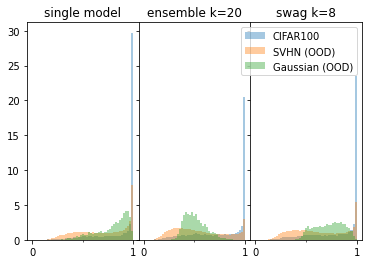

In [65]:
plt.figure(figsize=(7,3))
fig, (ax1,ax2, ax3) = plt.subplots(ncols=3, sharey=True) # frameon=False removes frames

# plt.subplot(1,3,1)
ax1.set_title('single model')
plot_prob_distributions([('CIFAR100', single), ('SVHN (OOD)', single_svhn), ('Gaussian (OOD)', single_n)], ax=ax1)
# plt.ylim((0,26))
# plt.subplot(1,3,2)
ax2.set_title('ensemble k=20')
plot_prob_distributions([('CIFAR100', ensemble_20), ('SVHN (OOD)', ensemble_20_svhn), ('Gaussian (OOD)', ensemble_20_n)], ax=ax2)

# plt.ylim((0,26))
# plt.subplot(1,3,3)
ax3.set_title('swag k=8')
plot_prob_distributions([('CIFAR100', swag), 
                         ('SVHN (OOD)', swag_svhn), 
                         ('Gaussian (OOD)', swag_n)], ax=ax3)
ax3.legend()

# plt.tight_layout()
plt.subplots_adjust(wspace=.0)
ax1.set_xticks([0,1])
ax1.set_xticks([0.5],True)
ax2.set_xticks([0,1])
ax2.set_xticks([0.5],True)
ax3.set_xticks([0,1])
ax3.set_xticks([0.5],True)
# plt.ylim((0,26))
# plt.yscale('log')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 45.0)

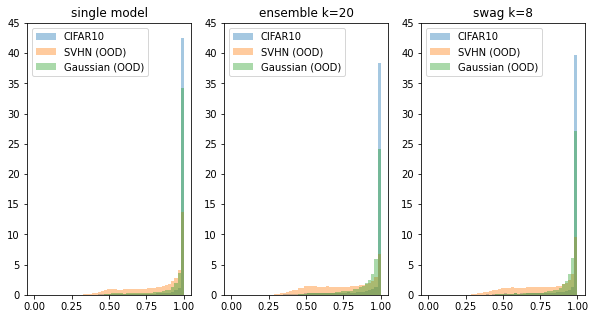

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title('single model')
plot_prob_distributions([('CIFAR10', single10), ('SVHN (OOD)', single10_svhn), ('Gaussian (OOD)', single10_n)])
plt.ylim((0,45))
plt.subplot(1,3,2)
plt.title('ensemble k=20')
plot_prob_distributions([('CIFAR10', ensemble10_20), ('SVHN (OOD)', ensemble10_20_svhn), ('Gaussian (OOD)', ensemble10_20_n)])
plt.ylim((0,45))
plt.subplot(1,3,3)
plt.title('swag k=8')
plot_prob_distributions([('CIFAR10', swag10), 
                         ('SVHN (OOD)', swag10_svhn), 
                         ('Gaussian (OOD)', swag10_n)])
plt.ylim((0,45))


## Entropy for in and out of domain

In [13]:
from scipy.stats import entropy

In [34]:
print('Entropy CIFAR100 VGG16')
print('\nSingle model')
print('CIFAR100:', entropy(single.T).mean())
# print('CIFAR100:', entropy(single[single_mask].T).mean())
# print('CIFAR100:', entropy(single[~single_mask].T).mean())
print('SVHN:', entropy(single_svhn.T).mean())
print('Gaussian:', entropy(single_n.T).mean())

print('\nEnsemble k=2')
print('CIFAR100:', entropy(ensemble_2.T).mean())
print('SVHN:', entropy(ensemble_2_svhn.T).mean())
print('Gaussian:', entropy(ensemble_2_n.T).mean())

print('\nEnsemble k=20')
print('CIFAR100:', entropy(ensemble_20.T).mean())
print('SVHN:', entropy(ensemble_20_svhn.T).mean())
print('Gaussian:', entropy(ensemble_20_n.T).mean())

print('\nSWAG k=8 (128)')
print('CIFAR100:', entropy(swag.T).mean())
# print('CIFAR100:', entropy(swag[swag_mask].T).mean())
# print('CIFAR100:', entropy(swag[~swag_mask].T).mean())
print('SVHN:', entropy(swag_svhn.T).mean())
print('Gaussian:', entropy(swag_n.T).mean())

print('\nEntropy CIFAR10 VGG16')
print('\nSingle model')
print('CIFAR10:', entropy(single10.T).mean())
print('SVHN:', entropy(single10_svhn.T).mean())
print('Gaussian:', entropy(single10_n.T).mean())

print('\nEnsemble k=2')
print('CIFAR10:', entropy(ensemble10_2.T).mean())
print('SVHN:', entropy(ensemble10_2_svhn.T).mean())
print('Gaussian:', entropy(ensemble10_2_n.T).mean())

print('\nEnsemble k=20')
print('CIFAR10:', entropy(ensemble10_20.T).mean())
print('SVHN:', entropy(ensemble10_20_svhn.T).mean())
print('Gaussian:', entropy(ensemble10_20_n.T).mean())

print('\nSWAG k=8 (128)')
print('CIFAR10:', entropy(swag10.T).mean())
print('SVHN:', entropy(swag10_svhn.T).mean())
print('Gaussian:', entropy(swag10_n.T).mean())

Entropy CIFAR100 VGG16

Single model
CIFAR100: 0.36590943
CIFAR100: 0.14601204
CIFAR100: 0.8030105
SVHN: 1.0064511
Gaussian: 0.70562893

Ensemble k=2
CIFAR100: 0.44262382
SVHN: 1.1445429
Gaussian: 0.606499

Ensemble k=20
CIFAR100: 0.6436284
SVHN: 1.4936976
Gaussian: 1.1913989

SWAG k=8 (128)
CIFAR100: 0.5235151
CIFAR100: 0.25477436
CIFAR100: 1.0993398
SVHN: 1.2464372
Gaussian: 0.71285266

Entropy CIFAR10 VGG16

Single model
CIFAR10: 0.070742406
SVHN: 0.4867465
Gaussian: 0.14269099

Ensemble k=2
CIFAR10: 0.090693675
SVHN: 0.50139767
Gaussian: 0.19741191

Ensemble k=20
CIFAR10: 0.127225
SVHN: 0.6670243
Gaussian: 0.23204009

SWAG k=8 (128)
CIFAR10: 0.10531652
SVHN: 0.6022755
Gaussian: 0.1957414


## OOD detection AUCROC (with max confidence as in-domain score)

## TODO: only use correctly classified samples?

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

def get_ood_aucroc(in_domain, ood):
    y = np.concatenate([in_domain, ood])
    t = np.concatenate([np.ones_like(in_domain), np.zeros_like(ood)])
    return roc_auc_score(t, y)

def get_ood_roc_curve(in_domain, ood):
    y = np.concatenate([in_domain, ood])
    t = np.concatenate([np.ones_like(in_domain), np.zeros_like(ood)])
    return roc_curve(t, y)

In [24]:
ensemble10_8_svhn, ensemble10_20_svhn

(array([[1.2593249e-02, 2.2220727e-04, 1.0368030e-02, ..., 1.0590546e-03,
         5.6364154e-03, 7.3393882e-04],
        [3.4198076e-02, 2.1728906e-03, 4.8866266e-01, ..., 8.7065209e-04,
         2.3494309e-02, 1.8676756e-04],
        [2.3233208e-01, 7.2238343e-03, 9.8441923e-03, ..., 2.2666473e-03,
         1.0078109e-01, 7.0542149e-04],
        ...,
        [7.4976647e-01, 3.1987362e-04, 3.0429054e-03, ..., 5.1954261e-04,
         4.7815878e-02, 4.0227271e-04],
        [4.7037218e-02, 4.8920943e-04, 7.9675525e-02, ..., 5.4519507e-04,
         2.0265402e-04, 5.3670032e-05],
        [7.3489137e-03, 2.0869485e-04, 3.0809881e-02, ..., 3.3410496e-04,
         8.8226021e-05, 2.0866642e-05]], dtype=float32),
 array([[1.7180001e-02, 4.0963749e-04, 1.0764668e-02, ..., 1.1172885e-03,
         6.1258175e-03, 1.4673318e-03],
        [8.6280584e-02, 3.0094045e-03, 5.3961241e-01, ..., 9.0501213e-04,
         1.7987739e-02, 1.6683001e-04],
        [2.4239728e-01, 5.6843152e-03, 1.1744766e-02, ...,

In [28]:
# print('\nCIFAR100 vs SVHN')
print(f'Single: & {get_ood_aucroc(single.max(axis=1), single_svhn.max(axis=1)):.6f}'
      f' & {get_ood_aucroc(single.max(axis=1), single_n.max(axis=1)):.6f}'
      f' & {get_ood_aucroc(single10.max(axis=1), single10_svhn.max(axis=1)):.6f}'
      f' & {get_ood_aucroc(single10.max(axis=1), single10_n.max(axis=1)):.6f} \\\\')


print(f'E k=8 {get_ood_aucroc(ensemble_8.max(axis=1), ensemble_8_svhn.max(axis=1)):.6f}'
      f' & {get_ood_aucroc(ensemble_8.max(axis=1), ensemble_8_n.max(axis=1)):.6f}'
      f' & {get_ood_aucroc(ensemble10_8.max(axis=1), ensemble10_8_svhn.max(axis=1)):.6f}'
      f' & {get_ood_aucroc(ensemble10_8.max(axis=1), ensemble10_8_n.max(axis=1)):.6f} \\\\')

print(f'E k=20 {get_ood_aucroc(ensemble_20.max(axis=1), ensemble_20_svhn.max(axis=1)):.6f}'
      f' & {get_ood_aucroc(ensemble_20.max(axis=1), ensemble_20_n.max(axis=1)):.6f}'
      f' & {get_ood_aucroc(ensemble10_20.max(axis=1), ensemble10_20_svhn.max(axis=1)):.6f}'
      f' & {get_ood_aucroc(ensemble10_20.max(axis=1), ensemble10_20_n.max(axis=1)):.6f} \\\\')

print(f'SWAG K=8 {get_ood_aucroc(swag.max(axis=1), swag_svhn.max(axis=1)):.6f}'
      f' & {get_ood_aucroc(swag.max(axis=1), swag_n.max(axis=1)):.6f}'
      f' & {get_ood_aucroc(swag10.max(axis=1), swag10_svhn.max(axis=1)):.6f}'
      f' & {get_ood_aucroc(swag10.max(axis=1), swag10_n.max(axis=1)):.6f} \\\\')


# print('E k=2 : ', get_ood_aucroc(ensemble_2.max(axis=1), ensemble_2_svhn.max(axis=1)))
# # print('E k=10: ', get_ood_aucroc(ensemble_10.max(axis=1), ensemble_10_svhn.max(axis=1)))
# # print('\nCIFAR100 vs Gaussian')
# print('E k=2 : ', get_ood_aucroc(ensemble_2.max(axis=1), ensemble_2_n.max(axis=1)))
# # print('E k=10: ', get_ood_aucroc(ensemble_10.max(axis=1), ensemble_10_n.max(axis=1)))
# # print('\nCIFAR10 vs SVHN')
# print('E k=2 : ', get_ood_aucroc(ensemble10_2.max(axis=1), ensemble10_2_svhn.max(axis=1)))
# # print('E k=10: ', get_ood_aucroc(ensemble10_10.max(axis=1), ensemble10_10_svhn.max(axis=1)))
# # print('\nCIFAR10 vs Gaussian')
# print('E k=2 : ', get_ood_aucroc(ensemble10_2.max(axis=1), ensemble10_2_n.max(axis=1)))
# # print('E k=10: ', get_ood_aucroc(ensemble10_10.max(axis=1), ensemble10_10_n.max(axis=1)))

Single: & 0.784062 & 0.763696 & 0.906522 & 0.814548 \\
E k=8 0.768016 & 0.748984 & 0.889072 & 0.796830 \\
E k=20 0.768292 & 0.819433 & 0.889354 & 0.787068 \\
SWAG K=8 0.755909 & 0.719460 & 0.891704 & 0.800886 \\


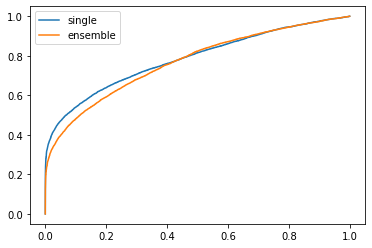

In [ ]:
fpr, tpr, thresholds = get_ood_roc_curve(single.max(axis=1), single_svhn.max(axis=1))
plt.plot(fpr, tpr, label='single')
fpr, tpr, thresholds = get_ood_roc_curve(ensemble_20.max(axis=1), ensemble_20_svhn.max(axis=1))
plt.plot(fpr, tpr, label='ensemble')
plt.legend()

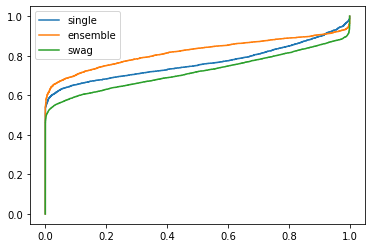

In [ ]:
fpr, tpr, thresholds = get_ood_roc_curve(single.max(axis=1), single_n.max(axis=1))
plt.plot(fpr, tpr, label='single')
fpr, tpr, thresholds = get_ood_roc_curve(ensemble_20.max(axis=1), ensemble_20_n.max(axis=1))
plt.plot(fpr, tpr, label='ensemble')
fpr, tpr, thresholds = get_ood_roc_curve(swag.max(axis=1), swag_n.max(axis=1))
plt.plot(fpr, tpr, label='swag')
plt.legend()

# Weight space visualisations

In [ ]:
predictions10, targets10 = get_preds('1eptvyat') # CIFAR10 interpolate
predictions100, targets100 = get_preds('3ji5gbi5') # CIFAR100 interpolate

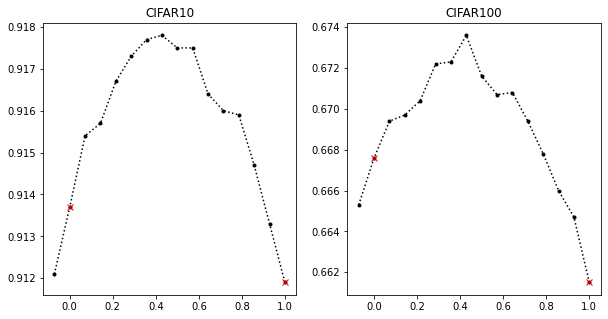

In [ ]:
n_samples = 16
locations = np.arange(-1/(n_samples-2), 1 + 2/(n_samples-2), 1/(n_samples-2))[:n_samples]
accuracies10 = []
accuracies100 = []
for i in range(n_samples):
  accuracies10.append(accuracy_score(targets10, predictions10[-i-1].argmax(axis=1)))
  accuracies100.append(accuracy_score(targets100, predictions100[-i-1].argmax(axis=1)))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('CIFAR10')
plt.plot(locations, accuracies10, 'k.:')
plt.plot([0], [accuracies10[1]], 'rx')
plt.plot([1], [accuracies10[-1]], 'rx')
# plt.ylabel('accuracy')
# plt.ylabel('relative location between checkpoints')
plt.subplot(1,2,2)
plt.title('CIFAR100')
plt.plot(locations, accuracies100, 'k.:')
plt.plot([0], [accuracies100[1]], 'rx')
plt.plot([1], [accuracies100[-1]], 'rx')
# plt.savefig()

In [ ]:
predictions10.shape

(16, 10000, 10)